# Quantum process tomography

This notebook loosely follows through the examples in the [corresponding Qiskit tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/6b_process_tomography.ipynb).

We perform quantum process tomography for two cases: a Hadamard gate, and a CNOT gate.

In [1]:
from qiskit import *

# Matplotlib is recommended for Qiskit. Others are for fun.
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# Load account (requires a saved IBMQ user id) and list available backends.
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
# Notebook widget for watching IBMQ jobs.
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

ibmq_london


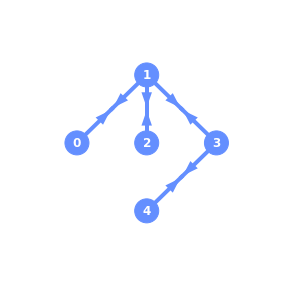

In [3]:
# Set least busy device as backend.
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_gate_map, plot_circuit_layout

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
backend = least_busy(small_devices)

# Set qasm as simulator.
simulator = Aer.get_backend('qasm_simulator')

# Print name and configuration.
print(backend)
plot_gate_map(backend, plot_directed=True)

## Example 1: X gate

### X gate circuit

In [4]:
# X gate.
qr = QuantumRegister(1)
x = QuantumCircuit(qr)
x.x(0)
print(x)

# Measurement circuit.
cr = ClassicalRegister(1)
meas = QuantumCircuit(qr, cr)
meas.barrier()
meas.measure(0, 0)
print(x+meas)

         ┌───┐
q0_0: |0>┤ X ├
         └───┘
         ┌───┐ ░ ┌─┐
q0_0: |0>┤ X ├─░─┤M├
         └───┘ ░ └╥┘
 c0_0: 0 ═════════╩═
                    


### Output of the X gate

In [5]:
# Run X gate.
job = execute(x+meas, backend, optimization_level=0, shots=5000)
print(job.job_id())

counts = job.result().get_counts()
print(counts)

# Simulate X gate.
counts_sim = execute(x+meas, simulator, shots=5000).result().get_counts()

5e4a0e24b917c90018a16f65
{'1': 4674, '0': 326}


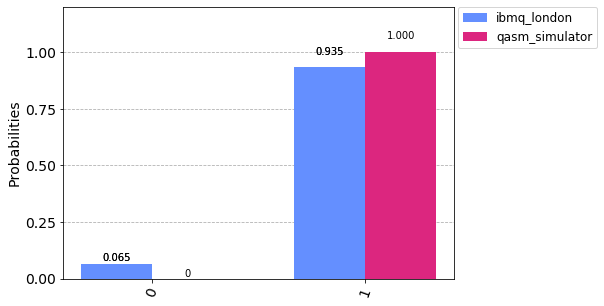

In [6]:
# Results from backend vs simulator.
from qiskit.visualization import plot_histogram
plot_histogram([counts, counts_sim], legend=[backend, simulator])

### Process tomography on the X gate

In [7]:
# Circuits for process tomography.
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
qpt_x = process_tomography_circuits(x, qr[0])

# Print circuits.
for circ in qpt_x:
    print(circ)

          ░ ┌───┐ ░ ┌───┐┌─┐
q0_0: |0>─░─┤ X ├─░─┤ H ├┤M├
          ░ └───┘ ░ └───┘└╥┘
 c1_0: 0 ═════════════════╩═
                            
          ░ ┌───┐ ░ ┌─────┐┌───┐┌─┐
q0_0: |0>─░─┤ X ├─░─┤ Sdg ├┤ H ├┤M├
          ░ └───┘ ░ └─────┘└───┘└╥┘
 c1_0: 0 ════════════════════════╩═
                                   
          ░ ┌───┐ ░ ┌─┐
q0_0: |0>─░─┤ X ├─░─┤M├
          ░ └───┘ ░ └╥┘
 c1_0: 0 ════════════╩═
                       
         ┌───┐ ░ ┌───┐ ░ ┌───┐┌─┐
q0_0: |0>┤ X ├─░─┤ X ├─░─┤ H ├┤M├
         └───┘ ░ └───┘ ░ └───┘└╥┘
 c1_0: 0 ══════════════════════╩═
                                 
         ┌───┐ ░ ┌───┐ ░ ┌─────┐┌───┐┌─┐
q0_0: |0>┤ X ├─░─┤ X ├─░─┤ Sdg ├┤ H ├┤M├
         └───┘ ░ └───┘ ░ └─────┘└───┘└╥┘
 c1_0: 0 ═════════════════════════════╩═
                                        
         ┌───┐ ░ ┌───┐ ░ ┌─┐
q0_0: |0>┤ X ├─░─┤ X ├─░─┤M├
         └───┘ ░ └───┘ ░ └╥┘
 c1_0: 0 ═════════════════╩═
                            
         ┌───┐ ░ ┌───┐ ░ ┌───┐┌─┐
q

In [8]:
# Process tomography circuits on backend.
job = execute(qpt_x, backend, optimization_level=0, shots=5000)
print(job.job_id())

5e4a0e4eea11110018f00053


In [9]:
# Calculate tomography data.
tomo_x = ProcessTomographyFitter(job.result(), qpt_x)
tomo_x.data

{(('Zp',), ('X',)): {'1': 2409, '0': 2591},
 (('Zp',), ('Y',)): {'1': 2323, '0': 2677},
 (('Zp',), ('Z',)): {'1': 4667, '0': 333},
 (('Zm',), ('X',)): {'1': 2351, '0': 2649},
 (('Zm',), ('Y',)): {'1': 2355, '0': 2645},
 (('Zm',), ('Z',)): {'1': 28, '0': 4972},
 (('Xp',), ('X',)): {'1': 15, '0': 4985},
 (('Xp',), ('Y',)): {'1': 2284, '0': 2716},
 (('Xp',), ('Z',)): {'1': 2243, '0': 2757},
 (('Yp',), ('X',)): {'1': 2309, '0': 2691},
 (('Yp',), ('Y',)): {'1': 4656, '0': 344},
 (('Yp',), ('Z',)): {'1': 2265, '0': 2735}}

CP? True. TP? False.


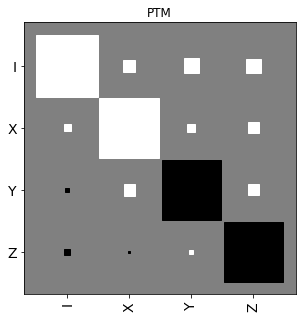

In [10]:
# Calculate the PTM.
from qiskit.quantum_info import PTM
choi_x = tomo_x.fit()
ptm_x = PTM(choi_x)
print('CP? '+str(ptm_x.is_cp())+'.', 'TP? '+str(ptm_x.is_tp())+'.')

# Plot PTM.
from qiskit.visualization import plot_state_hinton
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_state_hinton(ptm_x.data, ax_real=ax)

ax.set_title(r'PTM');
ax.set_xticklabels(['I', 'X', 'Y', 'Z']);
ax.set_yticklabels(['I', 'X', 'Y', 'Z']);

## Example 2: CNOT gate

### CNOT gate circuit

In [11]:
# CNOT gate.
qr = QuantumRegister(2)
cnot = QuantumCircuit(qr)
cnot.cx(0, 1)
print(cnot)

# Measurement circuit.
cr = ClassicalRegister(2)
meas = QuantumCircuit(qr, cr)
meas.barrier()
meas.measure([0,1], [0,1])
print(cnot+meas)

              
q1_0: |0>──■──
         ┌─┴─┐
q1_1: |0>┤ X ├
         └───┘
               ░ ┌─┐   
q1_0: |0>──■───░─┤M├───
         ┌─┴─┐ ░ └╥┘┌─┐
q1_1: |0>┤ X ├─░──╫─┤M├
         └───┘ ░  ║ └╥┘
 c2_0: 0 ═════════╩══╬═
                     ║ 
 c2_1: 0 ════════════╩═
                       


### Output of the CNOT gate

In [12]:
# Run CNOT circuit.
job = execute(cnot+meas, backend, optimization_level=0, shots=5000)
counts = job.result().get_counts()
print(job.job_id())
print(counts)

# Simulate CNOT ciruit.
counts_sim = execute(cnot+meas, simulator, shots=5000).result().get_counts()

5e4a0f9f912c8200183cb2ab
{'01': 13, '10': 73, '00': 4890, '11': 24}


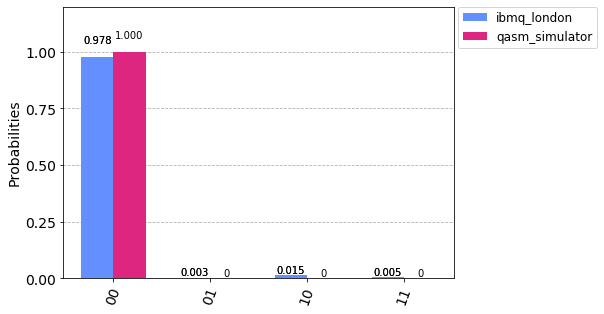

In [13]:
# Results from backend vs simulator.
from qiskit.visualization import plot_histogram
plot_histogram([counts, counts_sim], legend=[backend, simulator])

### Process tomography for a CNOT gate

In [14]:
# Calculate circuits for process tomography.
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
qpt_cnot = process_tomography_circuits(cnot, [qr[0], qr[1]])
print(len(qpt_cnot))

144


In [15]:
# Process tomography circuits on backend.
result = []
for n in range(len(qpt_cnot)//75 + 1): # Max circuits per job is 75.
    job = execute(qpt_cnot[n*75: (n+1)*75], backend, optimization_level=0, shots=5000)
    result.append(job.result()) # Loop will pause until results can be retrieved.
    print(job.job_id())

5e4a1010e2319f0018fea168
5e4a11b3912c8200183cb2bc


In [16]:
# Tomography data.
tomo_cnot = []
tomo_cnot = ProcessTomographyFitter(result[0], qpt_cnot[:75])
for n in range(1, len(qpt_cnot)//75 + 1):
    tomo_cnot.add_data(result[n], qpt_cnot[n*75 : (n+1)*75])
tomo_cnot.data

{(('Zp', 'Zp'), ('X', 'X')): {'01': 1309, '10': 1279, '00': 1366, '11': 1046},
 (('Zp', 'Zp'), ('X', 'Y')): {'01': 1257, '10': 1177, '00': 1478, '11': 1088},
 (('Zp', 'Zp'), ('X', 'Z')): {'01': 2293, '10': 49, '00': 2610, '11': 48},
 (('Zp', 'Zp'), ('Y', 'X')): {'01': 1217, '10': 1277, '00': 1488, '11': 1018},
 (('Zp', 'Zp'), ('Y', 'Y')): {'01': 1264, '10': 1159, '00': 1513, '11': 1064},
 (('Zp', 'Zp'), ('Y', 'Z')): {'01': 2264, '10': 64, '00': 2626, '11': 46},
 (('Zp', 'Zp'), ('Z', 'X')): {'01': 19, '10': 2289, '00': 2673, '11': 19},
 (('Zp', 'Zp'), ('Z', 'Y')): {'01': 13, '10': 2241, '00': 2718, '11': 28},
 (('Zp', 'Zp'), ('Z', 'Z')): {'01': 24, '10': 64, '00': 4882, '11': 30},
 (('Zp', 'Zm'), ('X', 'X')): {'01': 1262, '10': 1277, '00': 1429, '11': 1032},
 (('Zp', 'Zm'), ('X', 'Y')): {'01': 1219, '10': 1336, '00': 1323, '11': 1122},
 (('Zp', 'Zm'), ('X', 'Z')): {'01': 235, '10': 2412, '00': 163, '11': 2190},
 (('Zp', 'Zm'), ('Y', 'X')): {'01': 1232, '10': 1172, '00': 1542, '11': 1054

CP? True. TP? False.


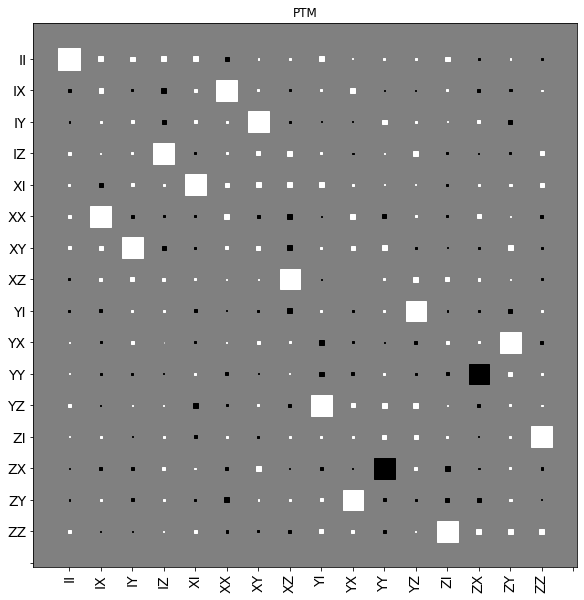

In [18]:
# Calculate PTM.
from qiskit.quantum_info import PTM
choi_cnot = tomo_cnot.fit()
ptm_cnot = PTM(choi_cnot)
print('CP? '+str(ptm_cnot.is_cp())+'.', 'TP? '+str(ptm_cnot.is_tp())+'.')

# Plot PTM.
from qiskit.visualization import plot_state_hinton
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_state_hinton(ptm_cnot.data, ax_real=ax)

labels = []
paulis = ['I', 'X', 'Y', 'Z']
for i in range(4):
    for j in range(4):
        labels.append(paulis[i]+paulis[j])
            
ax.set_title('PTM');
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);